In [116]:
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import itertools as itr
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
df = pd.read_csv('.data/datathon_2024_dataset.csv')
df["date"] = pd.to_datetime(df["game_date"], format='%Y%m%d')
print(df.head())

   Unnamed: 0  game_date home_team away_team  is_day_game  home_score  \
0           0   20000329       NYN       CHN        False           3   
1           1   20000330       CHN       NYN        False           1   
2           2   20000403       ATL       COL         True           2   
3           3   20000403       CIN       MIL         True           3   
4           4   20000403       FLO       SFN        False           6   

   away_score  venue        venue_name        city  ... away_pa  away_1b  \
0           5  TOK01        Tokyo Dome       Tokyo  ...      38        5   
1           5  TOK01        Tokyo Dome       Tokyo  ...      44        5   
2           0  ATL02      Turner Field     Atlanta  ...      32        5   
3           3  CIN08     Cinergy Field  Cincinnati  ...      20        3   
4           4  MIA01  Sun Life Stadium       Miami  ...      38        9   

   away_2b  away_3b  away_hr  away_fo  away_so  away_bb  away_hbp       date  
0        1        0      

In [54]:
df = df[['date', 'home_team', 'away_team', 'is_day_game', 'home_score', 'away_score', 'venue_name']]
print(df.head())

        date home_team away_team  is_day_game  home_score  away_score  \
0 2000-03-29       NYN       CHN        False           3           5   
1 2000-03-30       CHN       NYN        False           1           5   
2 2000-04-03       ATL       COL         True           2           0   
3 2000-04-03       CIN       MIL         True           3           3   
4 2000-04-03       FLO       SFN        False           6           4   

         venue_name  
0        Tokyo Dome  
1        Tokyo Dome  
2      Turner Field  
3     Cinergy Field  
4  Sun Life Stadium  


In [86]:
def baseline_runs(df, yr):
    yr_df = df[df['date'].dt.year == yr]
    teams = yr_df["home_team"].unique()
    teams.sort()
    run_score = {team:0 for team in teams}
    run_allow = {team:0 for team in teams}
    for ind in yr_df.index:
        home_team = yr_df.loc[ind, 'home_team']
        away_team = yr_df.loc[ind, 'away_team']
        home_runs = yr_df.loc[ind, 'home_score']
        away_runs = yr_df.loc[ind, 'away_score']
        run_score[home_team] += home_runs
        run_allow[away_team] += home_runs
        run_score[away_team] += away_runs
        run_allow[home_team] += away_runs
    n_runs = sum(run_score.values())
    p_run_score = {team: run / n_runs for team, run in run_score.items()}
    p_run_allow = {team: run / n_runs for team, run in run_allow.items()}
    run_df = pd.DataFrame(data=0, index=teams, columns=teams, dtype=float)
    for scorer, allower in itr.product(teams, teams):
        run_df.loc[scorer, allower] = (p_run_score[scorer] / p_run_allow[allower]) * (n_runs / len(yr_df.index) / 2)
    return run_df

baseline = {yr:baseline_runs(df, yr) for yr in tqdm(df['date'].dt.year.unique())}

100%|█| 24/24 [00:01<


In [90]:
df['exp_home_score'] = 0
df['exp_away_score'] = 0
df['exp_home_score'] = df['exp_home_score'].astype(float)
df['exp_away_score'] = df['exp_away_score'].astype(float)

for ind in tqdm(df.index):
    home_team = df.loc[ind, 'home_team']
    away_team = df.loc[ind, 'away_team']
    yr = df['date'].dt.year[ind]
    df.loc[ind, 'exp_home_score'] = baseline[yr].loc[home_team, away_team]
    df.loc[ind, 'exp_away_score'] = baseline[yr].loc[away_team, home_team]

100%|█| 56775/56775 [


In [80]:
tru_scores = np.array(df['home_score'].tolist() + df['away_score'].tolist())
exp_scores = np.array(df['exp_home_score'].tolist() + df['exp_away_score'].tolist())
res_scores = tru_scores - exp_scores

[-3.777975    2.44036244]
[1.05383105 2.17964873 3.58634534 4.92820954]


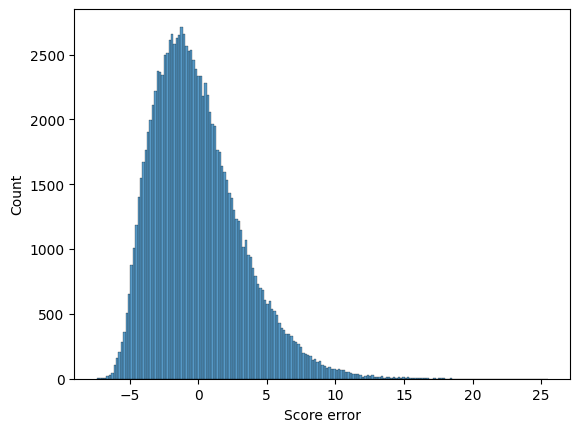

In [81]:
print(np.quantile(res_scores, [0.1, 0.8]))
print(np.quantile(np.abs(res_scores), [0.25, 0.50, 0.75, 0.90]))
sns.histplot(res_scores)
plt.xlabel("Score error")
plt.show()

In [94]:
def win_rates(df, yr):
    yr_df = df[df['date'].dt.year == yr]
    teams = yr_df["home_team"].unique()
    teams.sort()
    wins_df = pd.DataFrame(data=0, index=teams, columns=teams, dtype=int)
    decided_games_df = pd.DataFrame(data=0, index=teams, columns=teams, dtype=int)
    for ind in yr_df.index:
        home_runs = yr_df.loc[ind, 'home_score']
        away_runs = yr_df.loc[ind, 'away_score']
        if home_runs != away_runs:
            home_team = yr_df.loc[ind, 'home_team']
            away_team = yr_df.loc[ind, 'away_team']
            decided_games_df.loc[home_team, away_team] += 1
            decided_games_df.loc[away_team, home_team] += 1
            if home_runs > away_runs:
                wins_df.loc[home_team, away_team] += 1
            else:
                wins_df.loc[away_team, home_team] += 1
    return wins_df, decided_games_df

wins = {}
decided_games = {}
for yr in tqdm(baseline.keys()):
    wins_df, decided_games_df = win_rates(df, yr)
    wins[yr] = wins_df
    decided_games[yr] = decided_games_df

100%|█| 24/24 [00:11<


In [92]:
EXPONENT = 1.83

def pythag(run_df):
    pythag_df = pd.DataFrame(data=0, index=run_df.index, columns=run_df.columns, dtype=float)
    for scorer, allower in itr.product(run_df.index, run_df.columns):
        pythag_df.loc[scorer, allower] = 1 / (1 + (run_df.loc[allower, scorer] / run_df.loc[scorer, allower]) ** 1.83)
    return pythag_df

exp_winrate = {year:pythag(run_df) for year, run_df in baseline.items()}
print(exp_winrate)


{2000:           ANA       ARI       ATL       BAL       BOS       CHA       CHN  \
ANA  0.500000  0.603244  0.617188  0.516051  0.608491  0.459461  0.538136   
ARI  0.396756  0.500000  0.514653  0.412225  0.505494  0.358585  0.433850   
ATL  0.382812  0.485347  0.500000  0.398097  0.490838  0.345215  0.419509   
BAL  0.483949  0.587775  0.601903  0.500000  0.593089  0.443557  0.522139   
BOS  0.391509  0.494506  0.509162  0.406911  0.500000  0.353546  0.428460   
CHA  0.540539  0.641415  0.654785  0.556443  0.646454  0.500000  0.578191   
CHN  0.461864  0.566150  0.580491  0.477861  0.571540  0.421809  0.500000   
CIN  0.421214  0.525281  0.539874  0.436946  0.530757  0.382180  0.458855   
CLE  0.514618  0.617155  0.630908  0.530640  0.622333  0.474017  0.552636   
COL  0.566118  0.664861  0.677795  0.581822  0.669739  0.525857  0.603213   
DET  0.455214  0.559560  0.573954  0.471183  0.564969  0.415291  0.493304   
FLO  0.385996  0.488708  0.503363  0.401325  0.494200  0.348262  0.42

In [98]:
winrate = {yr: wins[yr].astype(float) / decided_games[yr].astype(float) for yr in baseline.keys()}
print(winrate)

{2000:           ANA       ARI       ATL       BAL       BOS       CHA       CHN  \
ANA       NaN  0.333333       NaN  0.583333  0.555556  0.400000       NaN   
ARI  0.666667       NaN  0.333333       NaN       NaN       NaN  0.555556   
ATL       NaN  0.666667       NaN  1.000000  0.666667       NaN  0.444444   
BAL  0.416667       NaN  0.000000       NaN  0.416667  0.400000       NaN   
BOS  0.444444       NaN  0.333333  0.583333       NaN  0.583333       NaN   
CHA  0.600000       NaN       NaN  0.600000  0.416667       NaN  0.500000   
CHN       NaN  0.444444  0.555556       NaN       NaN  0.500000       NaN   
CIN       NaN  0.714286  0.714286       NaN       NaN  0.000000  0.666667   
CLE  0.666667       NaN       NaN  0.444444  0.500000  0.384615       NaN   
COL  0.000000  0.461538  0.444444       NaN       NaN       NaN  0.555556   
DET  0.500000       NaN       NaN  0.400000  0.416667  0.250000  0.666667   
FLO       NaN  0.555556  0.500000  0.333333  0.333333       NaN  0.85

In [114]:
winrate_list = []
decided_games_list = []
exp_winrate_list = []
for yr in tqdm(baseline.keys()):
    winrate_list += winrate[yr].melt()['value'].tolist()
    decided_games_list += decided_games[yr].melt()['value'].tolist()
    exp_winrate_list += exp_winrate[yr].melt()['value'].tolist()

winrate_list = [elm for elm, dec_games in zip(winrate_list, decided_games_list) if dec_games > 0]
exp_winrate_list = [elm for elm, dec_games in zip(exp_winrate_list, decided_games_list) if dec_games > 0]
decided_games_list = [elm for elm in decided_games_list if elm > 0]

# print(len(winrate_list))
# print(len(exp_winrate_list))
# print(len(decided_games_list))

100%|█| 24/24 [00:00<

13820
13820
13820


<Axes: >

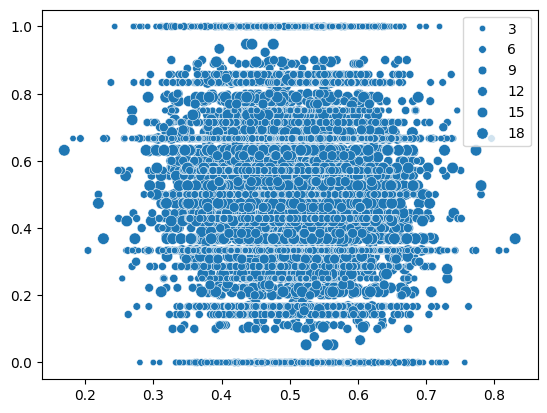

In [117]:
sns.scatterplot(x=exp_winrate_list, y=winrate_list, size=decided_games_list)

In [118]:
validation_fit = sm.WLS(winrate_list, exp_winrate_list, weights=decided_games_list).fit()
print(validation_fit.summary())

                                 WLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.844
Model:                            WLS   Adj. R-squared (uncentered):              0.844
Method:                 Least Squares   F-statistic:                          7.472e+04
Date:                Sat, 20 Jan 2024   Prob (F-statistic):                        0.00
Time:                        11:45:22   Log-Likelihood:                          591.92
No. Observations:               13820   AIC:                                     -1182.
Df Residuals:                   13819   BIC:                                     -1174.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [121]:
cov = np.cov(winrate_list, exp_winrate_list, aweights=decided_games_list)
print(cov[0, 1] / (np.sqrt(cov[0, 0]) * np.sqrt(cov[1, 1])))

-0.0780112738923191
